# Environment Setup

In [2]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
import math
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput
from tf2_gnn.layers.message_passing import RGAT, MessagePassingInput

# Data Setup

## Read SDF format data (structured-data format)

In [4]:
def read_sdf(file):
    # Open the file in read mode
    with open(file, 'r') as rf:
        # Read file into content
        content = rf.read()

    # Split the file up into a list by specified string 
    samples = content.split('$$$$')
    
    def parse_sample(s):
        # Split s at line boundaries (newline or return characters)
        lines = s.splitlines()
        # Lists for atoms, bonds, and label for the graph
        links = []
        nodes = []
        label = 0
        # For each line in s
        for l in lines:
            # Getting graph label
            # If line only contains 1.0 or -1.0, label as positive or negative respectively
            if l.strip() == '1.0':
                label = 1           # positive label
            if l.strip() == '-1.0':
                label = 0           # negative label
            # If line starts with 4 spaces, it's an atom, set up as node
            if l.startswith('    '):
                # Split the string at any whitespace
                feature = l.split()
                # Get the atom letter 
                node = feature[3]
                # add the atom to the list of nodes
                nodes.append(node)
            # If line starts with 1 spaces, it's a bond, set up as edge
            elif l.startswith(' '):
                # split values into a list
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        # Return the nodes, links, and the label for the compound graph
        return nodes, np.array(links), label
    
    # Generate the graph representation for each compound in samples
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                  

In [ ]:
# Load in training set and transform to graph configurations
training_set = read_sdf('train.sdf')
# Split into training and validation, holding out 15% of the data
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

In [ ]:
# Load in testing set and transform to graph configuration
testing_set  = read_sdf('test_x.sdf')

In [ ]:
# Validating data load in
print(training_set[0][1])

# Visualizing a Sample

In [8]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [9]:
colors = cm.rainbow(np.linspace(0, 1, 100))
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

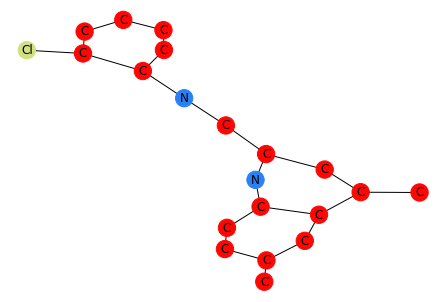

In [10]:
plt.clf()
visualize(training_set[20])

# Preprocessing:

In [11]:
# Max number of sequences to store in vocabulary
max_vocab = 500
# Max length of sequences in vocabulary - not used??
max_len = 100


# build vocabulary from training set
# Getting list of nodes for each compound
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [12]:
import random
random.seed(0)

# Generating sparse representation of graphs 
# Graphs of minibatch are joined into single graph of many disconnected components
def prepare_single_batch(samples):
    # Extract just the list of atoms for each compound
    sample_nodes = [s[0] for s in samples]
    # Transform list of atoms to sequence of integers
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # Pad sequences so they are all the same length for the batch
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # Get max number of nodes in a compound for this batch 
    # shape[0] is the number of compounds
    max_nodes_len = np.shape(sample_nodes)[1]
    # enumerate adds a counter to the samples
    # i is the index, s is the sample, s[1] is the edge list
    # Creating an adjacency matrix for the connections in each sample
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    # keep only rows that have connections in them
    edges = [e for e in edges if len(e) > 0]
    # tensor that maps the nodes to the correct graph in the batch
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    # reshape nodes into single vector for all nodes in batch
    all_nodes = np.reshape(sample_nodes, -1)
    # concatenate edge matrices for all the samples in batch into one array
    # this is an adjacency list
    all_edges = np.concatenate(edges)
    # reshape into single vector
    node_to_graph = np.reshape(node_to_graph, -1)
    # Returns a dictionary of the outputs 
    return {
        'data': all_nodes, # representation of each node in the graph 
        'edges': all_edges, # edge pairs as an adjacency list 
        'node2graph': node_to_graph, # map of nodes to graph in the batch
    }, np.array([s[2] for s in samples]) # labels for each compound in the batch


# Generating batches, default size 16 
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        # Make dataset to list type for shuffling
        dataset = list(dataset)
        if shuffle:
            # reorganize the order of the compounds
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            # get out batch_size number of samples 
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            np.shape(batch_samples)
            # create the batch by combining all the nodes into one matrix and 
            # all the edges into another matrix for the batch
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    # Printing the key and value for each of the elements returned by gen_batch
    for k,v in train_batch[0].items():
        print("k:", k)
        print("v:", v)
        pass
    print('label', train_batch[1])
    break

# Model Setup and Training

## Template

In [ ]:
# Input layer
data = keras.Input(batch_shape=(None,)) # [num_nodes, ]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # [num_edges, 2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # [num_nodes,]

embedded = Embedding(tokenizer.num_words, 20)(data) # [num_nodes, 20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 

gnn_input = GNNInput(
    node_features=embedded, # original representation of each node in the graph
    adjacency_lists=(edge,), # edges as adjacency list (e.g. [a,b] is an edge from node a to node b)
    node_to_graph_map=node2graph, # node_to_graph_map[v] = i means that node v belongs to graph i in the batch
    num_graphs=num_graph, # number of graphs in a batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32  # number of nodes/neurons in the hidden layers
gnn_layer = GNN(params)    # build the GNN with the set parameters
gnn_out = gnn_layer(gnn_input) # [num_nodes, hidden_dim] 

print('gnn_out:', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
# Dimension reduction for passing to Dense layer
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
) # [batch_size, hidden_dim]
print('mean:', avg)

# Dense layer for final prediction
pred = Dense(1, activation='sigmoid')(avg) # [None, 1]
print('pred:', pred)

# Build the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name='Template'
)

# Configure model for training
model.compile(
    loss='BinaryCrossentropy',
    # Metrics to be evaluated by the model during training and testing
    metrics=['AUC']
)

# Print out info about the model
model.summary()

In [ ]:
# Number of training examples to use in one iteration
# In this case, number of compounds to combine into one large graph
batch_size = 16
# Getting number of batches based on the size for steps_per_epoch argument 
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Number of forward and backward passes to perform through network 
epochs = 5

# Fit model to training data
history = model.fit(
    # Generate batches for training using function
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # Total number of steps before declaring one epoch finished and starting the next epoch
    epochs=epochs,
    # Generate batches for validation
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

## Aggregation Model 1: R-GCN

In [ ]:
# Input layer
data = keras.Input(batch_shape=(None,)) # [num_nodes, ]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # [num_edges, 2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # [num_nodes,]

embedded = Embedding(tokenizer.num_words, 20)(data) # [num_nodes, 20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 

gnn_input = GNNInput(
    node_features=embedded, # original representation of each node in the graph
    adjacency_lists=(edge,), # edges as adjacency list (e.g. [a,b] is an edge from node a to node b)
    node_to_graph_map=node2graph, # node_to_graph_map[v] = i means that node v belongs to graph i in the batch
    num_graphs=num_graph, # number of graphs in a batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["num_layers"] = 3                        # Number of layers in GNN
params["message_calculation_class"] = "rgcn"    # Aggregation method
params["hidden_dim"] = 64                       # Number of nodes/neurons in the hidden layers
gnn_layer = GNN(params) 
gnn_out = gnn_layer(gnn_input) # [num_nodes, hidden_dim]

print('gnn_out:', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
) # [batch_size, hidden_dim]
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # [None, 1]
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name='RGCN_2'
)

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

model.summary()

In [ ]:
print("Training: ", model.name)
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

epochs = 15

history = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

## Aggregation Model 2: GGNN

In [ ]:
# Input layer
data = keras.Input(batch_shape=(None,)) # [num_nodes, ]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # [num_edges, 2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # [num_nodes,]

embedded = Embedding(tokenizer.num_words, 20)(data) # [num_nodes, 20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 

gnn_input = GNNInput(
    node_features=embedded, # original representation of each node in the graph
    adjacency_lists=(edge,), # edges as adjacency list (e.g. [a,b] is an edge from node a to node b)
    node_to_graph_map=node2graph, # node_to_graph_map[v] = i means that node v belongs to graph i in the batch
    num_graphs=num_graph, # number of graphs in a batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["num_layers"] = 5                        # Number of layers in GNN
params["message_calculation_class"] = "ggnn"    # Aggregation method
params["hidden_dim"] = 8                        # Number of nodes/neurons in the hidden layers
gnn_layer = GNN(params) 
gnn_out = gnn_layer(gnn_input) # [num_nodes, hidden_dim]

print('gnn_out:', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
) # [batch_size, hidden_dim]
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # [None, 1]
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name='GGNN_4'
)

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

model.summary()

In [ ]:
print("Training: ", model.name)
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

epochs = 80

history = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

## Aggregation Model 3: RGAT

In [ ]:
# Input layer
data = keras.Input(batch_shape=(None,)) # [num_nodes, ]

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # [num_edges, 2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # [num_nodes,]

embedded = Embedding(tokenizer.num_words, 20)(data) # [num_nodes, 20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 

gnn_input = GNNInput(
    node_features=embedded, # original representation of each node in the graph
    adjacency_lists=(edge,), # edges as adjacency list (e.g. [a,b] is an edge from node a to node b)
    node_to_graph_map=node2graph, # node_to_graph_map[v] = i means that node v belongs to graph i in the batch
    num_graphs=num_graph, # number of graphs in a batch
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["num_layers"] = 2                        # Number of layers in GNN
params["message_calculation_class"] = "rgat"    # Aggregation method
params["num_heads"] = 32                        # heads for multi-head attention (I think?)
params["hidden_dim"] = 32                       # Number of nodes/neurons in the hidden layers
gnn_layer = GNN(params) 
gnn_out = gnn_layer(gnn_input) # [num_nodes, hidden_dim]

print('gnn_out:', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
) # [batch_size, hidden_dim]
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg) # [None, 1]
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2graph': node2graph,
    },
    outputs=pred,
    name='RGAT_4'
)

model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

model.summary()

In [ ]:
print("Training: ", model.name)
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

epochs = 15

history = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

# Model Visualization

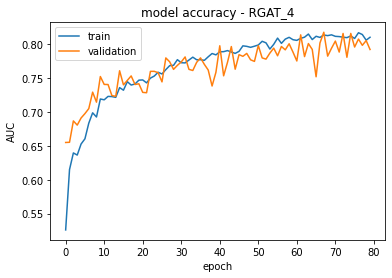

In [17]:
# Create AUC metric vs. epoch plot
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy - ' + model.name)
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Testing and Output

In [18]:
# Run test data through trained network
y_pred = model.predict(
    # Generate batches for the test data with batches the same size as the training
    gen_batch(testing_set, batch_size=batch_size, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
# Confirming the length of predictions are correct
len(y_pred) 

In [19]:
# Setting up file name
output_name = model.name + "_lay_" + str(params["num_layers"]) + "_bch_" + str(batch_size) + "_epc_" + str(epochs) + ".csv"

# Set up output into pandas dataframe in the correct format
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
# Output file for submission
submission.to_csv(output_name)